In [2]:
import os, importlib, sys, time

In [3]:
import numpy as np
import pandas as pd
import pyarrow
import matplotlib.pyplot as plt

In [4]:
import scipy.linalg as la
import scipy.stats as stats

In [5]:
import covidcast
from datetime import date

In [6]:
%load_ext jupyternotify

<IPython.core.display.Javascript object>

In [7]:
data = pd.read_feather('data/CovidCastStateAdj_2.feather').iloc[:,:-1]

In [8]:
data

,geo_value,time_value,deaths,completely_home_prop,median_home_dwell_time,full_time_work_prop,part_time_work_prop
0,al,2020-01-22,0.000000,0.183999,655.805922,0.086965,0.151171
1,al,2020-01-23,0.000000,0.171479,636.370230,0.103856,0.161668
2,al,2020-01-24,0.000000,0.169182,596.711830,0.104405,0.174012
3,al,2020-01-25,0.000000,0.172661,687.538565,0.083919,0.149298
4,al,2020-01-26,0.000000,0.193669,699.710495,0.087651,0.152943
...,...,...,...,...,...,...,...
9066,wv,2020-07-28,0.672611,0.273833,646.344539,0.039517,0.062896
9067,wv,2020-07-29,1.642459,0.270546,637.137487,0.042846,0.068807
9068,wv,2020-07-30,1.000000,0.266332,606.638365,0.051520,0.079922
9069,wv,2020-07-31,4.000000,0.246038,599.132159,0.041380,0.067567


In [9]:
iv=[5]

In [10]:
Y_raw = np.array(data[data.geo_value == 'ny'].deaths)
A_raw = np.array(data[data.geo_value == 'ny'].iloc[:,iv])

In [11]:
Y_raw.shape, A_raw.shape

((193,), (193, 1))

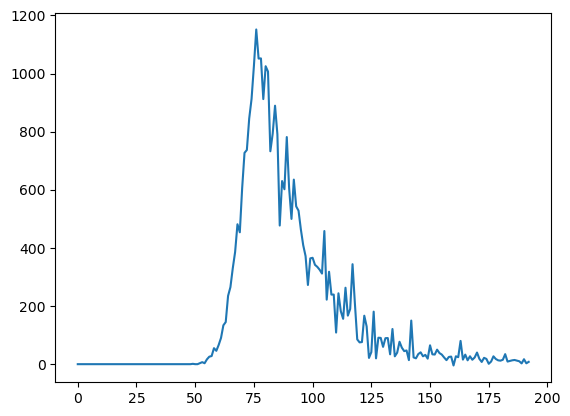

In [12]:
plt.plot(Y_raw)

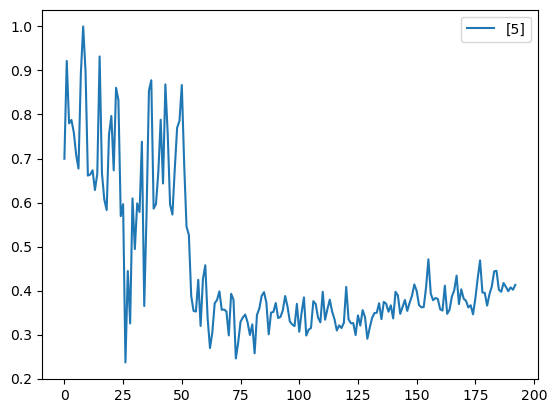

In [13]:
plt.plot(A_raw/np.max(A_raw, 0), label=iv)
plt.legend()

# 2. EDA

In [14]:
POI = np.sum(np.cumsum(Y_raw) < 10)
Y_data = np.maximum(np.round(Y_raw[POI:]), 0).astype(int)

In [15]:
T = Y_data.shape[0]
T0 = 20
alpha = 1
K = 6.5

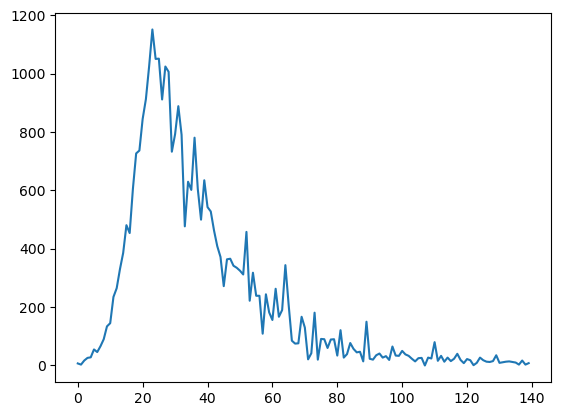

In [16]:
plt.plot(Y_data)

In [17]:
GPi = np.load('data/GPi.npz')

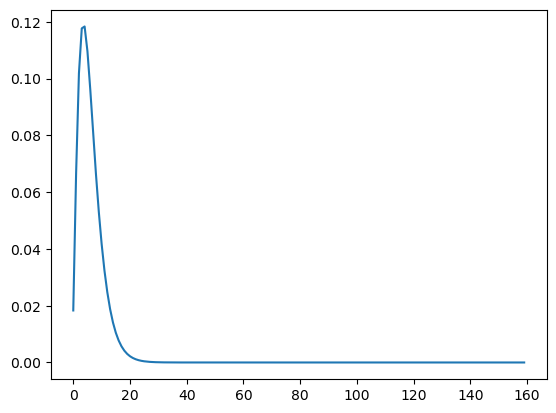

In [18]:
# g
g = np.zeros(T+T0)
g[:GPi['g'].shape[0]] = GPi['g']
plt.plot(g)

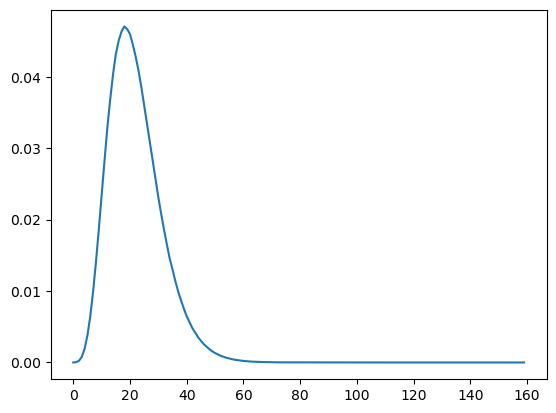

In [19]:
# pi
pi = np.zeros(T+T0)
pi[:GPi['pi'].shape[0]] = GPi['pi']
plt.plot(pi)

In [20]:
# A
d = len(iv)+1
A = np.zeros([T+T0, d])

In [21]:
A[:,0] = np.full(T+T0, 1)
A[:,1:] = A_raw[POI-T0:,:]/np.max(A_raw[:,:], 0)

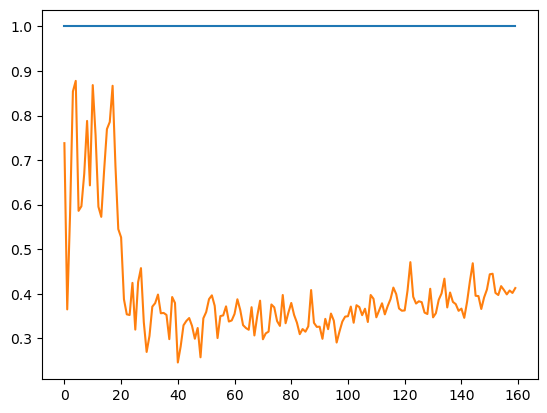

In [22]:
plt.plot(A)

# 3. fit by EM algorithm

In [23]:
def NBLL(y, m, r):
    y = int(y)
    return (np.sum(np.log(1+(r-1)/(np.arange(y)+1))) 
            + r * np.log(r/(r+m)) 
            + y * np.log(m/(r+m)))

In [24]:
def dNBLLdr(y, m, r):
    y = int(y)
    return (np.sum(1/(np.arange(y)+r)) + np.log(r/(r+m)) + (m-y)/(r+m))

In [25]:
def d2NBLLdr2(y, m, r):
    y = int(y)
    return (-np.sum(1/(np.arange(y)+r)**2) + 1/r + 1/(r+m) - (m-y)/(r+m)**2)

In [26]:
def fit(obs, rinit, minit_0, binit,
        n_iter=3000, history=False, verbose=False, step_size=0.1):
    
    rhat = rinit
    mhat_0 = minit_0
    bhat= np.array(binit)
    ss = np.inf
        
    if history:
        rhs = np.zeros(n_iter)
        mhs_0 = np.zeros(n_iter)
        bhs = np.zeros([n_iter, d])
        lls = np.zeros(n_iter)
        
    Rhat = np.zeros(T+T0)
    d1Rh = np.zeros([d, T+T0])
    d2Rh = np.zeros([d, d, T+T0])
    
    for t in np.arange(T+T0):
        o = np.exp(- bhat @ A[t])
        p = 1 / (1 + o)
        q = o / (1 + o)

        Rhat[t] = K * p
        d1Rh[:,t] = K * p * q * A[t]
        d2Rh[:,:,t] = K * p * q * (q - p) * (A[t,:,None] * A[t])

    Pi = alpha * np.concatenate([[0],pi])[np.maximum(0, T0 + np.arange(T)[:,None] - np.arange(T+T0))]
    G = Rhat[:,None] * np.concatenate([[0],g])[np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
    inv_ImG = la.inv(np.eye(T+T0)-G)
    Pi_inv_ImG = Pi @ inv_ImG
    
    EY = mhat_0 * Pi_inv_ImG[:,0]
    ll = np.sum([NBLL(y, m, rhat) for y, m in zip(obs, EY)])
    
    if verbose:
        print("Before EM, ll: %f"%ll)
    
    for i in np.arange(n_iter):
        start_iter = time.time()

        # derivatives
        d1G = d1Rh[:,:,None] * np.concatenate([[0],g])[
                np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
        d2G = d2Rh[...,None] * np.concatenate([[0],g])[
                np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
        
        d1EY = mhat_0 * (Pi_inv_ImG @ (d1G @ inv_ImG[:,:1]))[...,0]
        d2EY = mhat_0 * (Pi_inv_ImG @ (
            d1G[:,None] @ inv_ImG @ d1G @ inv_ImG[:,:1]
            + d1G @ inv_ImG @ d1G[:,None] @ inv_ImG[:,:1]
            + d2G @ inv_ImG[:,:1]))[...,0]
        
        # first derivative
        dldEY = obs/EY - (rhat+obs)/(rhat+EY)
        
        dldr = np.sum([dNBLLdr(y, m, rhat) for y, m in zip(obs, EY)])
        dldm = np.sum(dldEY * Pi_inv_ImG[:,0])
        dldb = np.sum(dldEY * d1EY, 1)

        dldth = np.concatenate([[dldr, dldm], dldb])
        
        # second deivative
        d2ldEY2 = - obs/EY**2 + (rhat+obs)/(rhat+EY)**2
        d2ldrdEY = - 1/(rhat+EY) + (rhat+obs)/(rhat+EY)**2

        d2ldr2 = np.sum([d2NBLLdr2(y, m, rhat) for y, m in zip(obs, EY)])
        d2ldm2 = np.sum(d2ldEY2 * Pi_inv_ImG[:,0]**2)
        d2ldb2 = np.sum(d2ldEY2 * d1EY * d1EY[:,None,:], 2) \
               + np.sum(dldEY * d2EY, 2)

        d2ldrdm = np.sum(d2ldrdEY * Pi_inv_ImG[:,0])
        d2ldrdb = np.sum(d2ldrdEY * d1EY, 1)
        d2ldmdb = np.sum(d2ldEY2 * Pi_inv_ImG[:,0] * d1EY, 1) \
                + np.sum(dldEY * (Pi_inv_ImG @ (d1G @ inv_ImG[:,:1]))[...,0], 1)
        
        d2ldrm2 = np.array([[d2ldr2, d2ldrdm],
                            [d2ldrdm, d2ldm2]])
        d2ldrmdb = np.stack([d2ldrdb, 
                             d2ldmdb])
        
        d2ldth2 = np.block([[d2ldrm2, d2ldrmdb],
                            [d2ldrmdb.T, d2ldb2]])
        
        # Newton's method
        u, v = la.eig(-d2ldth2)
        # dth = np.real(((v/u) @ v.T) @ dldth)
        dth = np.real(((v/np.maximum(u,np.max(u)/10000)) @ v.T) @ dldth)
        ss = np.min([1, 1/np.sqrt(np.sum(dth**2))])
        
        rhat = np.abs(rhat + ss * dth[0])
        mhat_0 = mhat_0 + ss * dth[1]
        bhat = bhat + ss * dth[2:]
        
        for t in np.arange(T+T0):
            o = np.exp(- bhat @ A[t])
            p = 1 / (1 + o)
            q = o / (1 + o)

            Rhat[t] = K * p
            d1Rh[:,t] = K * p * q * A[t]
            d2Rh[:,:,t] = K * p * q * (q - p) * (A[t,:,None] * A[t])

        Pi = alpha * np.concatenate([[0],pi])[np.maximum(0, T0 + np.arange(T)[:,None] - np.arange(T+T0))]
        G = Rhat[:,None] * np.concatenate([[0],g])[np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
        inv_ImG = la.inv(np.eye(T+T0)-G)
        Pi_inv_ImG = Pi @ inv_ImG
    
        EY = mhat_0 * Pi_inv_ImG[:,0]
        ll = np.sum([NBLL(y, m, rhat) for y, m in zip(obs, EY)])
    
        if history:
            rhs[i] = rhat
            mhs_0[i] = mhat_0
            bhs[i] = bhat
            lls[i] = ll
        
        if verbose:
            print("%d-th iteration finished, ll: %f, lapse: %.3fsec."
                  %(i+1, ll, time.time()-start_iter))
            
    if history:
        return rhs, mhs_0, bhs
    else:
        return rhat, mhat_0, bhat

In [27]:
rmle = 2.5
mmle_0 = 30
bmle = np.zeros(A.shape[-1])

In [28]:
%%notify
rhs, mhs_0, bhs =\
    fit(Y_data, rmle, mmle_0, bmle, 
        history=True, verbose=True, n_iter=2000, step_size=1)

Before EM, ll: -4724.119260
1-th iteration finished, ll: -3558.018180, lapse: 0.027sec.
2-th iteration finished, ll: -3188.469117, lapse: 0.031sec.
3-th iteration finished, ll: -2680.842236, lapse: 0.020sec.
4-th iteration finished, ll: -2029.566481, lapse: 0.015sec.
5-th iteration finished, ll: -1309.561647, lapse: 0.021sec.
6-th iteration finished, ll: -1148.783029, lapse: 0.015sec.
7-th iteration finished, ll: -1128.821668, lapse: 0.019sec.
8-th iteration finished, ll: -1113.362910, lapse: 0.008sec.
9-th iteration finished, ll: -1096.846509, lapse: 0.021sec.
10-th iteration finished, ll: -1078.953917, lapse: 0.010sec.
11-th iteration finished, ll: -1059.744258, lapse: 0.017sec.
12-th iteration finished, ll: -1039.867909, lapse: 0.047sec.
13-th iteration finished, ll: -1019.737163, lapse: 0.022sec.
14-th iteration finished, ll: -1012.711676, lapse: 0.020sec.
15-th iteration finished, ll: -983.117669, lapse: 0.018sec.
16-th iteration finished, ll: -950.799041, lapse: 0.022sec.
17-th i

144-th iteration finished, ll: -737.914410, lapse: 0.029sec.
145-th iteration finished, ll: -737.908217, lapse: 0.021sec.
146-th iteration finished, ll: -737.902033, lapse: 0.017sec.
147-th iteration finished, ll: -737.895858, lapse: 0.021sec.
148-th iteration finished, ll: -737.889694, lapse: 0.009sec.
149-th iteration finished, ll: -737.883539, lapse: 0.028sec.
150-th iteration finished, ll: -737.877394, lapse: 0.009sec.
151-th iteration finished, ll: -737.871259, lapse: 0.021sec.
152-th iteration finished, ll: -737.865135, lapse: 0.009sec.
153-th iteration finished, ll: -737.859021, lapse: 0.017sec.
154-th iteration finished, ll: -737.852917, lapse: 0.009sec.
155-th iteration finished, ll: -737.846824, lapse: 0.013sec.
156-th iteration finished, ll: -737.840742, lapse: 0.021sec.
157-th iteration finished, ll: -737.834671, lapse: 0.036sec.
158-th iteration finished, ll: -737.828611, lapse: 0.027sec.
159-th iteration finished, ll: -737.822562, lapse: 0.010sec.
160-th iteration finishe

280-th iteration finished, ll: -737.214817, lapse: 0.023sec.
281-th iteration finished, ll: -737.211132, lapse: 0.061sec.
282-th iteration finished, ll: -737.207473, lapse: 0.011sec.
283-th iteration finished, ll: -737.203840, lapse: 0.034sec.
284-th iteration finished, ll: -737.200232, lapse: 0.018sec.
285-th iteration finished, ll: -737.196650, lapse: 0.012sec.
286-th iteration finished, ll: -737.193094, lapse: 0.013sec.
287-th iteration finished, ll: -737.189564, lapse: 0.020sec.
288-th iteration finished, ll: -737.186060, lapse: 0.013sec.
289-th iteration finished, ll: -737.182582, lapse: 0.026sec.
290-th iteration finished, ll: -737.179129, lapse: 0.024sec.
291-th iteration finished, ll: -737.175703, lapse: 0.034sec.
292-th iteration finished, ll: -737.172302, lapse: 0.031sec.
293-th iteration finished, ll: -737.168928, lapse: 0.029sec.
294-th iteration finished, ll: -737.165579, lapse: 0.019sec.
295-th iteration finished, ll: -737.162257, lapse: 0.027sec.
296-th iteration finishe

419-th iteration finished, ll: -736.930651, lapse: 0.031sec.
420-th iteration finished, ll: -736.929921, lapse: 0.032sec.
421-th iteration finished, ll: -736.929202, lapse: 0.019sec.
422-th iteration finished, ll: -736.928495, lapse: 0.022sec.
423-th iteration finished, ll: -736.927800, lapse: 0.049sec.
424-th iteration finished, ll: -736.927117, lapse: 0.024sec.
425-th iteration finished, ll: -736.926444, lapse: 0.025sec.
426-th iteration finished, ll: -736.925783, lapse: 0.031sec.
427-th iteration finished, ll: -736.925132, lapse: 0.013sec.
428-th iteration finished, ll: -736.924493, lapse: 0.031sec.
429-th iteration finished, ll: -736.923864, lapse: 0.016sec.
430-th iteration finished, ll: -736.923246, lapse: 0.012sec.
431-th iteration finished, ll: -736.922639, lapse: 0.011sec.
432-th iteration finished, ll: -736.922041, lapse: 0.023sec.
433-th iteration finished, ll: -736.921454, lapse: 0.008sec.
434-th iteration finished, ll: -736.920877, lapse: 0.017sec.
435-th iteration finishe

557-th iteration finished, ll: -736.893513, lapse: 0.031sec.
558-th iteration finished, ll: -736.893465, lapse: 0.024sec.
559-th iteration finished, ll: -736.893418, lapse: 0.026sec.
560-th iteration finished, ll: -736.893372, lapse: 0.011sec.
561-th iteration finished, ll: -736.893327, lapse: 0.025sec.
562-th iteration finished, ll: -736.893283, lapse: 0.013sec.
563-th iteration finished, ll: -736.893240, lapse: 0.017sec.
564-th iteration finished, ll: -736.893198, lapse: 0.011sec.
565-th iteration finished, ll: -736.893157, lapse: 0.007sec.
566-th iteration finished, ll: -736.893117, lapse: 0.028sec.
567-th iteration finished, ll: -736.893078, lapse: 0.009sec.
568-th iteration finished, ll: -736.893039, lapse: 0.052sec.
569-th iteration finished, ll: -736.893001, lapse: 0.027sec.
570-th iteration finished, ll: -736.892965, lapse: 0.020sec.
571-th iteration finished, ll: -736.892929, lapse: 0.015sec.
572-th iteration finished, ll: -736.892893, lapse: 0.013sec.
573-th iteration finishe

692-th iteration finished, ll: -736.891467, lapse: 0.023sec.
693-th iteration finished, ll: -736.891465, lapse: 0.019sec.
694-th iteration finished, ll: -736.891463, lapse: 0.024sec.
695-th iteration finished, ll: -736.891460, lapse: 0.013sec.
696-th iteration finished, ll: -736.891458, lapse: 0.020sec.
697-th iteration finished, ll: -736.891457, lapse: 0.010sec.
698-th iteration finished, ll: -736.891455, lapse: 0.010sec.
699-th iteration finished, ll: -736.891453, lapse: 0.015sec.
700-th iteration finished, ll: -736.891451, lapse: 0.012sec.
701-th iteration finished, ll: -736.891449, lapse: 0.020sec.
702-th iteration finished, ll: -736.891447, lapse: 0.013sec.
703-th iteration finished, ll: -736.891446, lapse: 0.027sec.
704-th iteration finished, ll: -736.891444, lapse: 0.011sec.
705-th iteration finished, ll: -736.891443, lapse: 0.022sec.
706-th iteration finished, ll: -736.891441, lapse: 0.015sec.
707-th iteration finished, ll: -736.891439, lapse: 0.021sec.
708-th iteration finishe

834-th iteration finished, ll: -736.891379, lapse: 0.025sec.
835-th iteration finished, ll: -736.891379, lapse: 0.030sec.
836-th iteration finished, ll: -736.891379, lapse: 0.020sec.
837-th iteration finished, ll: -736.891379, lapse: 0.017sec.
838-th iteration finished, ll: -736.891379, lapse: 0.009sec.
839-th iteration finished, ll: -736.891378, lapse: 0.022sec.
840-th iteration finished, ll: -736.891378, lapse: 0.007sec.
841-th iteration finished, ll: -736.891378, lapse: 0.012sec.
842-th iteration finished, ll: -736.891378, lapse: 0.018sec.
843-th iteration finished, ll: -736.891378, lapse: 0.013sec.
844-th iteration finished, ll: -736.891378, lapse: 0.018sec.
845-th iteration finished, ll: -736.891378, lapse: 0.009sec.
846-th iteration finished, ll: -736.891378, lapse: 0.010sec.
847-th iteration finished, ll: -736.891378, lapse: 0.017sec.
848-th iteration finished, ll: -736.891378, lapse: 0.017sec.
849-th iteration finished, ll: -736.891378, lapse: 0.023sec.
850-th iteration finishe

973-th iteration finished, ll: -736.891376, lapse: 0.021sec.
974-th iteration finished, ll: -736.891376, lapse: 0.020sec.
975-th iteration finished, ll: -736.891376, lapse: 0.023sec.
976-th iteration finished, ll: -736.891376, lapse: 0.011sec.
977-th iteration finished, ll: -736.891376, lapse: 0.012sec.
978-th iteration finished, ll: -736.891376, lapse: 0.013sec.
979-th iteration finished, ll: -736.891376, lapse: 0.006sec.
980-th iteration finished, ll: -736.891376, lapse: 0.020sec.
981-th iteration finished, ll: -736.891376, lapse: 0.015sec.
982-th iteration finished, ll: -736.891376, lapse: 0.018sec.
983-th iteration finished, ll: -736.891376, lapse: 0.014sec.
984-th iteration finished, ll: -736.891376, lapse: 0.015sec.
985-th iteration finished, ll: -736.891376, lapse: 0.012sec.
986-th iteration finished, ll: -736.891376, lapse: 0.023sec.
987-th iteration finished, ll: -736.891376, lapse: 0.010sec.
988-th iteration finished, ll: -736.891376, lapse: 0.030sec.
989-th iteration finishe

1114-th iteration finished, ll: -736.891376, lapse: 0.011sec.
1115-th iteration finished, ll: -736.891376, lapse: 0.025sec.
1116-th iteration finished, ll: -736.891376, lapse: 0.016sec.
1117-th iteration finished, ll: -736.891376, lapse: 0.019sec.
1118-th iteration finished, ll: -736.891376, lapse: 0.011sec.
1119-th iteration finished, ll: -736.891376, lapse: 0.021sec.
1120-th iteration finished, ll: -736.891376, lapse: 0.008sec.
1121-th iteration finished, ll: -736.891376, lapse: 0.019sec.
1122-th iteration finished, ll: -736.891376, lapse: 0.007sec.
1123-th iteration finished, ll: -736.891376, lapse: 0.014sec.
1124-th iteration finished, ll: -736.891376, lapse: 0.018sec.
1125-th iteration finished, ll: -736.891376, lapse: 0.012sec.
1126-th iteration finished, ll: -736.891376, lapse: 0.020sec.
1127-th iteration finished, ll: -736.891376, lapse: 0.013sec.
1128-th iteration finished, ll: -736.891376, lapse: 0.020sec.
1129-th iteration finished, ll: -736.891376, lapse: 0.035sec.
1130-th 

1253-th iteration finished, ll: -736.891376, lapse: 0.026sec.
1254-th iteration finished, ll: -736.891376, lapse: 0.021sec.
1255-th iteration finished, ll: -736.891376, lapse: 0.011sec.
1256-th iteration finished, ll: -736.891376, lapse: 0.033sec.
1257-th iteration finished, ll: -736.891376, lapse: 0.034sec.
1258-th iteration finished, ll: -736.891376, lapse: 0.015sec.
1259-th iteration finished, ll: -736.891376, lapse: 0.014sec.
1260-th iteration finished, ll: -736.891376, lapse: 0.030sec.
1261-th iteration finished, ll: -736.891376, lapse: 0.008sec.
1262-th iteration finished, ll: -736.891376, lapse: 0.018sec.
1263-th iteration finished, ll: -736.891376, lapse: 0.008sec.
1264-th iteration finished, ll: -736.891376, lapse: 0.014sec.
1265-th iteration finished, ll: -736.891376, lapse: 0.034sec.
1266-th iteration finished, ll: -736.891376, lapse: 0.024sec.
1267-th iteration finished, ll: -736.891376, lapse: 0.020sec.
1268-th iteration finished, ll: -736.891376, lapse: 0.011sec.
1269-th 

1395-th iteration finished, ll: -736.891376, lapse: 0.014sec.
1396-th iteration finished, ll: -736.891376, lapse: 0.046sec.
1397-th iteration finished, ll: -736.891376, lapse: 0.017sec.
1398-th iteration finished, ll: -736.891376, lapse: 0.024sec.
1399-th iteration finished, ll: -736.891376, lapse: 0.015sec.
1400-th iteration finished, ll: -736.891376, lapse: 0.024sec.
1401-th iteration finished, ll: -736.891376, lapse: 0.013sec.
1402-th iteration finished, ll: -736.891376, lapse: 0.017sec.
1403-th iteration finished, ll: -736.891376, lapse: 0.009sec.
1404-th iteration finished, ll: -736.891376, lapse: 0.017sec.
1405-th iteration finished, ll: -736.891376, lapse: 0.012sec.
1406-th iteration finished, ll: -736.891376, lapse: 0.022sec.
1407-th iteration finished, ll: -736.891376, lapse: 0.021sec.
1408-th iteration finished, ll: -736.891376, lapse: 0.011sec.
1409-th iteration finished, ll: -736.891376, lapse: 0.011sec.
1410-th iteration finished, ll: -736.891376, lapse: 0.008sec.
1411-th 

1537-th iteration finished, ll: -736.891376, lapse: 0.020sec.
1538-th iteration finished, ll: -736.891376, lapse: 0.032sec.
1539-th iteration finished, ll: -736.891376, lapse: 0.018sec.
1540-th iteration finished, ll: -736.891376, lapse: 0.056sec.
1541-th iteration finished, ll: -736.891376, lapse: 0.022sec.
1542-th iteration finished, ll: -736.891376, lapse: 0.010sec.
1543-th iteration finished, ll: -736.891376, lapse: 0.021sec.
1544-th iteration finished, ll: -736.891376, lapse: 0.013sec.
1545-th iteration finished, ll: -736.891376, lapse: 0.015sec.
1546-th iteration finished, ll: -736.891376, lapse: 0.011sec.
1547-th iteration finished, ll: -736.891376, lapse: 0.029sec.
1548-th iteration finished, ll: -736.891376, lapse: 0.031sec.
1549-th iteration finished, ll: -736.891376, lapse: 0.015sec.
1550-th iteration finished, ll: -736.891376, lapse: 0.012sec.
1551-th iteration finished, ll: -736.891376, lapse: 0.013sec.
1552-th iteration finished, ll: -736.891376, lapse: 0.008sec.
1553-th 

1676-th iteration finished, ll: -736.891376, lapse: 0.048sec.
1677-th iteration finished, ll: -736.891376, lapse: 0.013sec.
1678-th iteration finished, ll: -736.891376, lapse: 0.018sec.
1679-th iteration finished, ll: -736.891376, lapse: 0.012sec.
1680-th iteration finished, ll: -736.891376, lapse: 0.035sec.
1681-th iteration finished, ll: -736.891376, lapse: 0.008sec.
1682-th iteration finished, ll: -736.891376, lapse: 0.019sec.
1683-th iteration finished, ll: -736.891376, lapse: 0.013sec.
1684-th iteration finished, ll: -736.891376, lapse: 0.013sec.
1685-th iteration finished, ll: -736.891376, lapse: 0.012sec.
1686-th iteration finished, ll: -736.891376, lapse: 0.008sec.
1687-th iteration finished, ll: -736.891376, lapse: 0.024sec.
1688-th iteration finished, ll: -736.891376, lapse: 0.008sec.
1689-th iteration finished, ll: -736.891376, lapse: 0.017sec.
1690-th iteration finished, ll: -736.891376, lapse: 0.016sec.
1691-th iteration finished, ll: -736.891376, lapse: 0.026sec.
1692-th 

1809-th iteration finished, ll: -736.891376, lapse: 0.039sec.
1810-th iteration finished, ll: -736.891376, lapse: 0.021sec.
1811-th iteration finished, ll: -736.891376, lapse: 0.026sec.
1812-th iteration finished, ll: -736.891376, lapse: 0.013sec.
1813-th iteration finished, ll: -736.891376, lapse: 0.014sec.
1814-th iteration finished, ll: -736.891376, lapse: 0.013sec.
1815-th iteration finished, ll: -736.891376, lapse: 0.007sec.
1816-th iteration finished, ll: -736.891376, lapse: 0.019sec.
1817-th iteration finished, ll: -736.891376, lapse: 0.015sec.
1818-th iteration finished, ll: -736.891376, lapse: 0.018sec.
1819-th iteration finished, ll: -736.891376, lapse: 0.015sec.
1820-th iteration finished, ll: -736.891376, lapse: 0.025sec.
1821-th iteration finished, ll: -736.891376, lapse: 0.013sec.
1822-th iteration finished, ll: -736.891376, lapse: 0.019sec.
1823-th iteration finished, ll: -736.891376, lapse: 0.012sec.
1824-th iteration finished, ll: -736.891376, lapse: 0.024sec.
1825-th 

1946-th iteration finished, ll: -736.891376, lapse: 0.014sec.
1947-th iteration finished, ll: -736.891376, lapse: 0.015sec.
1948-th iteration finished, ll: -736.891376, lapse: 0.020sec.
1949-th iteration finished, ll: -736.891376, lapse: 0.008sec.
1950-th iteration finished, ll: -736.891376, lapse: 0.010sec.
1951-th iteration finished, ll: -736.891376, lapse: 0.015sec.
1952-th iteration finished, ll: -736.891376, lapse: 0.014sec.
1953-th iteration finished, ll: -736.891376, lapse: 0.021sec.
1954-th iteration finished, ll: -736.891376, lapse: 0.016sec.
1955-th iteration finished, ll: -736.891376, lapse: 0.020sec.
1956-th iteration finished, ll: -736.891376, lapse: 0.030sec.
1957-th iteration finished, ll: -736.891376, lapse: 0.010sec.
1958-th iteration finished, ll: -736.891376, lapse: 0.021sec.
1959-th iteration finished, ll: -736.891376, lapse: 0.017sec.
1960-th iteration finished, ll: -736.891376, lapse: 0.015sec.
1961-th iteration finished, ll: -736.891376, lapse: 0.017sec.
1962-th 

<IPython.core.display.Javascript object>

In [29]:
rmle = rhs[-1]
mmle_0 = mhs_0[-1]
bmle = bhs[-1]

In [30]:
rmle, mmle_0, bmle

(3.9995083313522537, 16.83136498811501, array([-6.261947 , 11.9256005]))

## plots

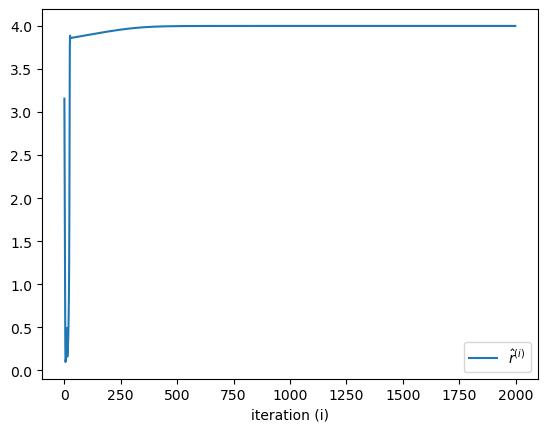

In [31]:
plt.plot(rhs, label=r"$\hat{r}^{(i)}$")
plt.xlabel("iteration (i)"); plt.legend()

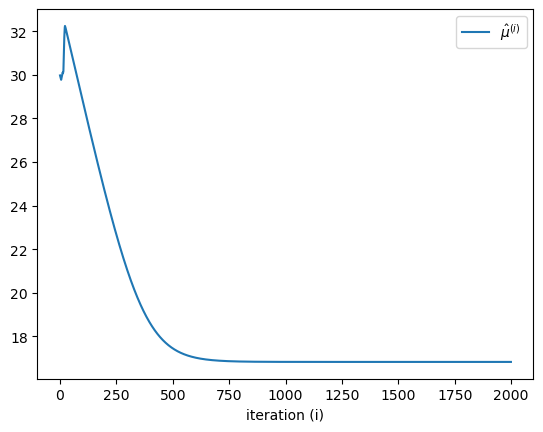

In [32]:
plt.plot(mhs_0, label=r"$\hat{\mu}^{(i)}$")
plt.xlabel("iteration (i)"); plt.legend()

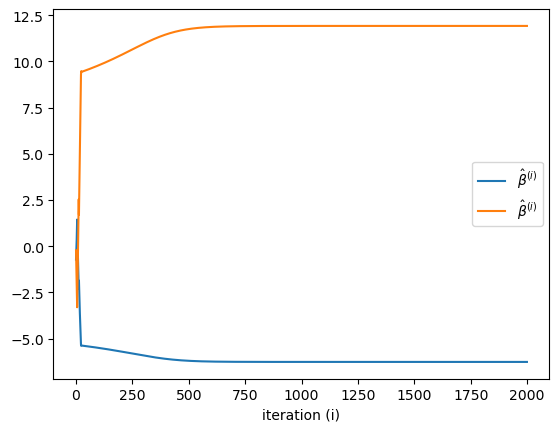

In [33]:
plt.plot(bhs, label=r"$\hat{\beta}^{(i)}$")
plt.xlabel("iteration (i)"); plt.legend()

# 4. Wald's Confidence Region

In [34]:
Rmle = np.zeros(T+T0)
d1Rm = np.zeros([d, T+T0])
d2Rm = np.zeros([d, d, T+T0])

In [35]:
for t in np.arange(T+T0):
    o = np.exp(- bmle @ A[t])
    p = 1 / (1 + o)
    q = o / (1 + o)

    Rmle[t] = K * p
    d1Rm[:,t] = K * p * q * A[t]
    d2Rm[:,:,t] = K * p * q * (q - p) * (A[t,:,None] * A[t])

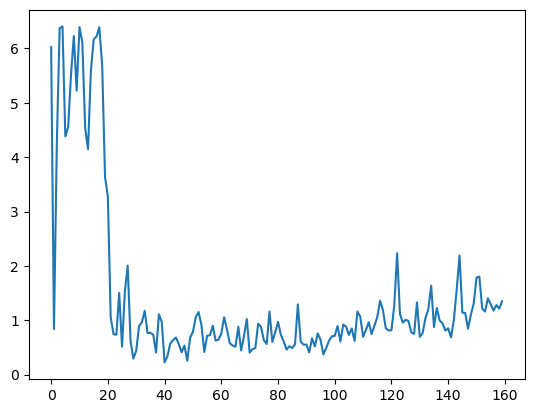

In [36]:
plt.plot(Rmle)

In [37]:
Pi = alpha * np.concatenate([[0],pi])[np.maximum(0, T0 + np.arange(T)[:,None] - np.arange(T+T0))]
G = Rmle[:,None] * np.concatenate([[0],g])[np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]

In [38]:
d1G = d1Rm[:,:,None] * np.concatenate([[0],g])[
        np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
d2G = d2Rm[...,None] * np.concatenate([[0],g])[
        np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]

In [39]:
inv_ImG = la.inv(np.eye(T+T0)-G)

In [40]:
Pi_inv_ImG = Pi @ inv_ImG

In [41]:
EY = mmle_0 * Pi_inv_ImG[:,0]

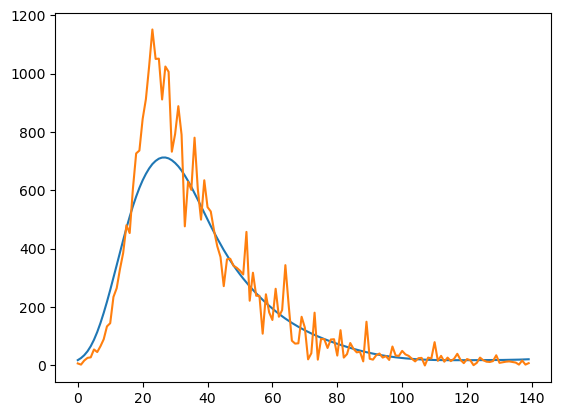

In [42]:
plt.plot(EY)
plt.plot(Y_data)

In [44]:
p = rmle / (EY + rmle)
q = EY / (EY + rmle)
VarY = EY / p

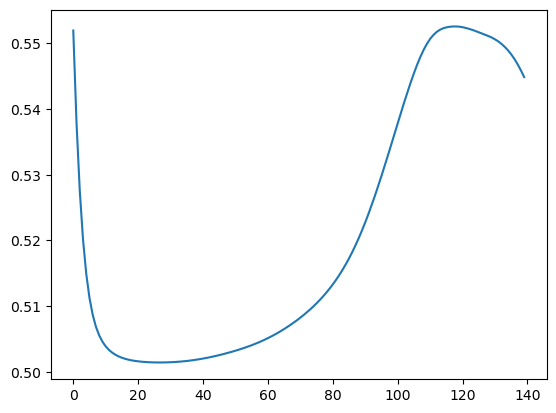

In [48]:
plt.plot(np.sqrt(VarY)/EY)

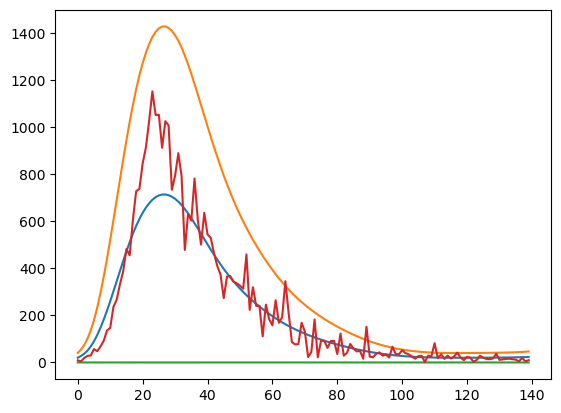

In [46]:
plt.plot(EY)
plt.plot(EY+2*np.sqrt(VarY))
plt.plot(EY-2*np.sqrt(VarY))
plt.plot(Y_data)

In [46]:
d1EY = mmle_0 * (Pi_inv_ImG @ (d1G @ inv_ImG[:,:1]))[...,0]

In [47]:
d2EY = mmle_0 * (Pi_inv_ImG @ (
    d1G[:,None] @ inv_ImG @ d1G @ inv_ImG[:,:1]
    + d1G @ inv_ImG @ d1G[:,None] @ inv_ImG[:,:1]
    + d2G @ inv_ImG[:,:1]))[...,0]

In [48]:
dldEY = Y_data/EY - (rmle+Y_data)/(rmle+EY)
d2ldEY2 = - Y_data/EY**2 + (rmle+Y_data)/(rmle+EY)**2
d2ldrdEY = - 1/(rmle+EY) + (rmle+Y_data)/(rmle+EY)**2

In [49]:
d2ldr2 = np.sum([d2NBLLdr2(y, m, rmle) for y, m in zip(Y_data, EY)])
d2ldm2 = np.sum(d2ldEY2 * Pi_inv_ImG[:,0]**2)
d2ldb2 = np.sum(d2ldEY2 * d1EY * d1EY[:,None,:], 2) \
       + np.sum(dldEY * d2EY, 2)

d2ldrdm = np.sum(d2ldrdEY * Pi_inv_ImG[:,0])
d2ldrdb = np.sum(d2ldrdEY * d1EY, 1)
d2ldmdb = np.sum(d2ldEY2 * Pi_inv_ImG[:,0] * d1EY, 1) \
        + np.sum(dldEY * (Pi_inv_ImG @ (d1G @ inv_ImG[:,:1]))[...,0], 1)

In [50]:
d2ldrm2 = np.array([[d2ldr2, d2ldrdm],
                    [d2ldrdm, d2ldm2]])
d2ldrmdb = np.stack([d2ldrdb, 
                     d2ldmdb])

In [51]:
Ihat_dth = - np.block([[d2ldrm2, d2ldrmdb],
                       [d2ldrmdb.T, d2ldb2]])

In [52]:
Ihat_dth

array([[-1.68179473e+00, -9.26795090e-03, -5.55033485e-01,
        -2.68363099e-01],
       [-9.26795090e-03,  1.83244343e+00,  1.86473670e+02,
         7.28785757e+01],
       [-5.55033485e-01,  1.86473670e+02,  2.73409929e+04,
         1.04132984e+04],
       [-2.68363099e-01,  7.28785757e+01,  1.04132984e+04,
         3.97272039e+03]])

In [53]:
la.inv(Ihat_dth)[2:,2:]

array([[ 0.26548879, -0.7406794 ],
       [-0.7406794 ,  2.06733068]])

In [54]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def confidence_ellipse(mean, cov, ax, n_std=2.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """

    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = mean[0]

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = mean[1]

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

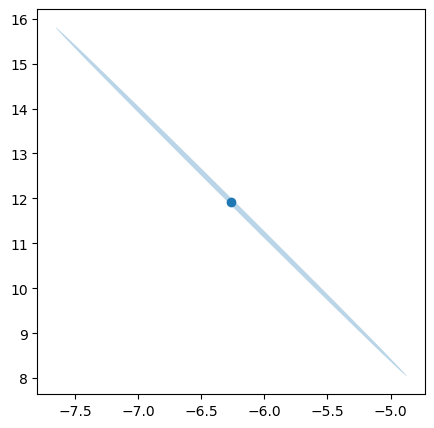

In [70]:
plt.figure(figsize=(5,5))
p = plt.scatter(*bmle)
confidence_ellipse(bmle, np.linalg.pinv(Ihat_dth)[2:,2:], 
                   plt.gca(), n_std=2.7, facecolor=p.get_facecolor(), alpha=0.3)

In [236]:
def EY_t(beta, mu_0, A):
    assert A.shape[0] > T0
    
    T = A.shape[0]-T0
    R = np.zeros(T+T0)
    for t in np.arange(T+T0):
        o = np.exp(- beta @ A[t])
        p = 1 / (1 + o)
        R[t] = K * p 
        
    # g
    g = np.zeros(T+T0)
    g[:np.minimum(T+T0,len(GPi['g']))] \
    = GPi['g'][:np.minimum(T+T0,len(GPi['g']))]
    
    # pi
    pi = np.zeros(T+T0)
    pi[:np.minimum(T+T0,len(GPi['pi']))] \
    = GPi['pi'][:np.minimum(T+T0,len(GPi['pi']))]
        
    Pi = alpha * np.concatenate([[0],pi])[np.maximum(0, T0 + np.arange(T)[:,None] - np.arange(T+T0))]
    G = R[:,None] * np.concatenate([[0],g])[np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
    
    return mu_0 * np.linalg.inv(np.eye(T+T0)-G)[:,0] @ Pi.T

In [237]:
num_sim = 20
chi_sim = np.linspace(-2.4, 2.4, num_sim)

In [238]:
u, v = np.linalg.eig(np.linalg.pinv(Ihat_dth)[2:,2:])

In [239]:
u

array([1.05944358e-04, 2.33271352e+00])

In [240]:
beta_sim = bmle + v[:,1] * np.sqrt(u[1]) * chi_sim[:,None]
EY_sim = np.zeros([num_sim, T])

In [241]:
for i, b in enumerate(beta_sim):
    EY_sim[i] = EY_t(b, mmle_0, A)

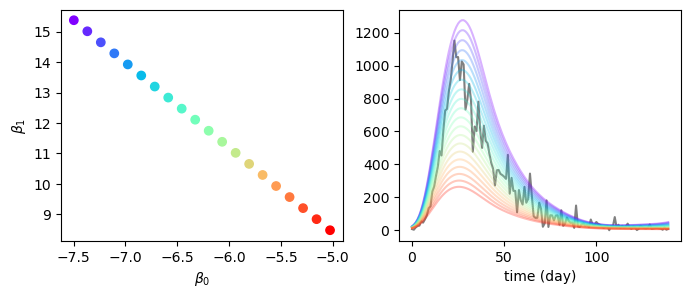

In [242]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.scatter(beta_sim[:,0],beta_sim[:,1], c=chi_sim, cmap='rainbow')
plt.xlabel(r'$\beta_0$'); plt.ylabel(r'$\beta_1$')

plt.subplot(1,2,2); 
plt.plot(Y_data, color='grey')
lines = plt.plot(EY_sim.T, alpha=0.3)
plt.xlabel('time (day)'); # plt.ylabel('expected deaths')
for i, l in enumerate(lines):
    l.set_color(plt.cm.rainbow(i/num_sim))
plt.show()

In [243]:
u, v = np.linalg.eig(np.linalg.pinv(Ihat_dth)[1:,1:])

In [244]:
u

array([2.66373697e+01, 1.58518636e-01, 3.19392635e-05])

In [245]:
v[:,0]

array([ 0.95806411,  0.09626261, -0.26990124])

In [195]:
beta_sim = bmle + v[1:,0] * np.sqrt(u[0]) * chi_sim[:,None]
m0_sim = mmle_0 + v[0,0] * np.sqrt(u[0]) * chi_sim[:,None]
EY_sim = np.zeros([num_sim, T])

In [196]:
for i, (m0, b) in enumerate(zip(m0_sim,beta_sim)):
    EY_sim[i] = EY_t(b, m0, A)

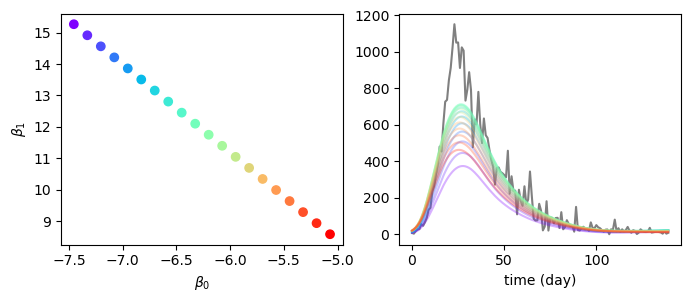

In [197]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.scatter(beta_sim[:,0],beta_sim[:,1], c=chi_sim, cmap='rainbow')
plt.xlabel(r'$\beta_0$'); plt.ylabel(r'$\beta_1$')

plt.subplot(1,2,2); 
plt.plot(Y_data, color='grey')
lines = plt.plot(EY_sim.T, alpha=0.3)
plt.xlabel('time (day)'); # plt.ylabel('expected deaths')
for i, l in enumerate(lines):
    l.set_color(plt.cm.rainbow(i/num_sim))
plt.show()

# 5. Sandwich estimator

In [139]:
L_HAC = np.floor(4* (T/100)**(2/9))

In [140]:
w_HAC = np.maximum(1 - np.abs(np.arange(T)[:,None] - np.arange(T))/L_HAC, 0)

In [141]:
dltdr = np.array([dNBLLdr(y, m, rmle) for y, m in zip(Y_data, EY)])
dltdm = dldEY * Pi_inv_ImG[:,0]
dltdb = dldEY * d1EY

In [142]:
dltdth = np.concatenate([np.array([dltdr, dltdm]), dltdb], 0)

In [143]:
VEdl = dltdth @ w_HAC @ dltdth.T

In [144]:
VEdl

array([[ 8.73612373e+00,  4.62098661e-01, -3.09019428e+01,
        -9.18382370e+00],
       [ 4.62098661e-01,  2.60337350e+00,  2.86076908e+02,
         1.10607997e+02],
       [-3.09019428e+01,  2.86076908e+02,  4.98337089e+04,
         1.88170194e+04],
       [-9.18382370e+00,  1.10607997e+02,  1.88170194e+04,
         7.11305850e+03]])

In [145]:
Ihat_sdw = Ihat_dth @ la.inv(VEdl) @ Ihat_dth

In [146]:
Ihat_sdw

array([[3.55535985e-01, 1.38299902e-01, 1.62246208e+00, 1.11600236e+00],
       [1.38299902e-01, 1.58032299e+00, 1.31757733e+02, 5.27199499e+01],
       [1.62246208e+00, 1.31757733e+02, 1.60423087e+04, 6.19033624e+03],
       [1.11600236e+00, 5.27199499e+01, 6.19033624e+03, 2.39597029e+03]])

In [147]:
Ihat_dth

array([[-1.68179473e+00, -9.26795090e-03, -5.55033485e-01,
        -2.68363099e-01],
       [-9.26795090e-03,  1.83244343e+00,  1.86473670e+02,
         7.28785757e+01],
       [-5.55033485e-01,  1.86473670e+02,  2.73409929e+04,
         1.04132984e+04],
       [-2.68363099e-01,  7.28785757e+01,  1.04132984e+04,
         3.97272039e+03]])

In [148]:
la.inv(Ihat_sdw)[2:,2:]

array([[ 0.66094509, -1.8610656 ],
       [-1.8610656 ,  5.24198431]])

In [224]:
num_sim = 20
chi_sim = np.linspace(-2.4, 2.4, num_sim)

In [225]:
u, v = np.linalg.eig(np.linalg.pinv(Ihat_sdw)[2:,2:])

In [226]:
u

array([1.86125312e-04, 5.90274328e+00])

In [227]:
beta_sim = bmle + v[:,1] * np.sqrt(u[1]) * chi_sim[:,None]
EY_sim = np.zeros([num_sim, T])

In [228]:
for i, b in enumerate(beta_sim):
    EY_sim[i] = EY_t(b, mmle_0, A)

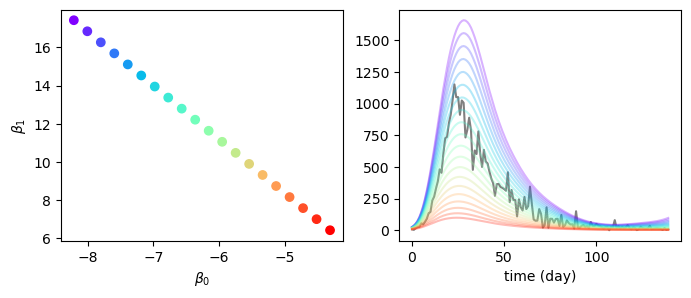

In [229]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.scatter(beta_sim[:,0],beta_sim[:,1], c=chi_sim, cmap='rainbow')
plt.xlabel(r'$\beta_0$'); plt.ylabel(r'$\beta_1$')

plt.subplot(1,2,2); 
plt.plot(Y_data, color='grey')
lines = plt.plot(EY_sim.T, alpha=0.3)
plt.xlabel('time (day)'); # plt.ylabel('expected deaths')
for i, l in enumerate(lines):
    l.set_color(plt.cm.rainbow(i/num_sim))
plt.show()

In [230]:
num_sim = 20
chi_sim = np.linspace(-2, 2, num_sim)

In [231]:
u, v = np.linalg.eig(np.linalg.pinv(Ihat_sdw)[1:,1:])

In [232]:
u

array([8.18481721e+01, 1.61994329e-01, 5.42808210e-05])

In [233]:
beta_sim = bmle + v[1:,0] * np.sqrt(u[0]) * chi_sim[:,None]
m0_sim = mmle_0 + v[0,0] * np.sqrt(u[0]) * chi_sim[:,None]
EY_sim = np.zeros([num_sim, T])

In [234]:
for i, (m0, b) in enumerate(zip(m0_sim,beta_sim)):
    EY_sim[i] = EY_t(b, m0, A)

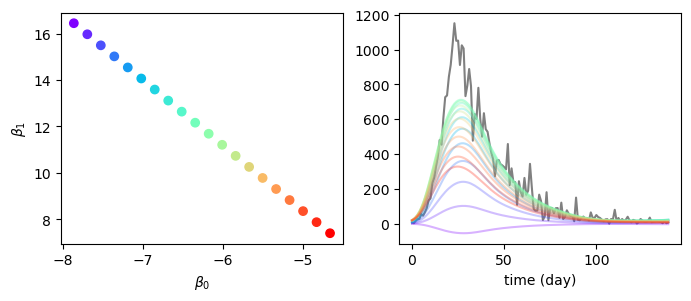

In [235]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.scatter(beta_sim[:,0],beta_sim[:,1], c=chi_sim, cmap='rainbow')
plt.xlabel(r'$\beta_0$'); plt.ylabel(r'$\beta_1$')

plt.subplot(1,2,2); 
plt.plot(Y_data, color='grey')
lines = plt.plot(EY_sim.T, alpha=0.3)
plt.xlabel('time (day)'); # plt.ylabel('expected deaths')
for i, l in enumerate(lines):
    l.set_color(plt.cm.rainbow(i/num_sim))
plt.show()

# 6. Causal forecasting

In [82]:
Tf = 50
Af = np.zeros([Tf, d])

In [169]:
Af[:,0] = np.full(Tf, 1)
Af[:,1] = np.full(Tf, 0.5)

In [170]:
Te = T+Tf
Ae = np.concatenate([A, Af], 0)

In [171]:
# g
ge = np.zeros(Te+T0)
ge[:GPi['g'].shape[0]] = GPi['g']

# pi
pie = np.zeros(Te+T0)
pie[:GPi['pi'].shape[0]] = GPi['pi']

In [172]:
num_sim = 1000

In [173]:
bsim = np.random.multivariate_normal(bmle, la.inv(Ihat_dth)[2:,2:], num_sim)

In [174]:
Rmle = np.zeros(Te+T0)
Rsim = np.zeros([num_sim,Te+T0])

In [175]:
for t in np.arange(Te+T0):
    o = np.exp(- bmle @ Ae[t])
    p = 1 / (1 + o)
    Rmle[t] = K * p
    
    o = np.exp(- bsim @ Ae[t])
    p = 1 / (1 + o)
    Rsim[:,t] = K * p

In [176]:
Pie = alpha * np.concatenate([[0],pie])[np.maximum(0, T0 + np.arange(Te)[:,None] - np.arange(Te+T0))]
Ge = Rmle[:,None] * np.concatenate([[0],ge])[np.maximum(0, np.arange(Te+T0)[:,None] - np.arange(Te+T0))]
Gesim = Rsim[:,:,None] * np.concatenate([[0],ge])[np.maximum(0, np.arange(Te+T0)[:,None] - np.arange(Te+T0))]

In [177]:
EYf = mmle_0 * np.linalg.inv(np.eye(Te+T0)-Ge)[:,0] @ Pie.T
EYf_sim = mmle_0 * np.linalg.inv(np.eye(Te+T0)-Gesim)[:,:,0] @ Pie.T

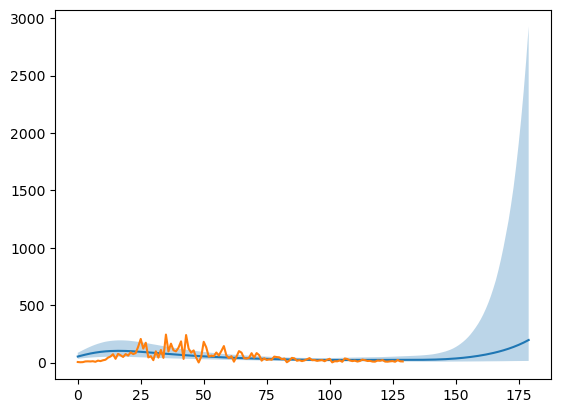

In [180]:
plt.plot(EYf)
plt.fill_between(np.arange(Te), np.quantile(EYf_sim, 0.975, 0), np.quantile(EYf_sim, 0.025, 0),
                 alpha=0.3)
plt.plot(Y_data)

In [ ]:
EY_sim